<a href="https://colab.research.google.com/github/vicknentura/ML-in-SQL-BigQuery/blob/main/Google_Cloud_x_MLB(TM)_Hackathon_Exploring_MLB_Provided_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import Python Libraries
# General data science libraries
import pandas as pd
import numpy as np

# Pulling data from APIs, parsing JSON
import requests
import json

# Interfacing w/ Cloud Storage from Python
from google.cloud import storage

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML Evaluation
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [ ]:
#@title Modify Settings

# Expand max column width when displaying data frames to handle longer text
pd.set_option('display.max_colwidth', 200)

In [ ]:
#@title Function to Load Newline Delimited JSON into Pandas DF
def load_newline_delimited_json(url):
    """Loads a newline-delimited JSON file from a URL into a pandas DataFrame.

    Args:
        url: The URL of the newline-delimited JSON file.

    Returns:
        A pandas DataFrame containing the data, or None if an error occurs.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        data = []
        for line in response.text.strip().split('\n'):
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line} due to error: {e}")

        return pd.DataFrame(data)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading data: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [ ]:
#@title Function to Process Results from Various MLB Stats API Endpoints
def process_endpoint_url(endpoint_url, pop_key=None):
  """
  Fetches data from a URL, parses JSON, and optionally pops a key.

  Args:
    endpoint_url: The URL to fetch data from.
    pop_key: The key to pop from the JSON data (optional, defaults to None).

  Returns:
    A pandas DataFrame containing the processed data
  """
  json_result = requests.get(endpoint_url).content

  data = json.loads(json_result)

   # if pop_key is provided, pop key and normalize nested fields
  if pop_key:
    df_result = pd.json_normalize(data.pop(pop_key), sep = '_')
  # if pop_key is not provided, normalize entire json
  else:
    df_result = pd.json_normalize(data)

  return df_result

# **Methodology 📓**

1. Train the regression-based prediction model using the MLB statistics on each player from each team.
  * Test linear regression, LASSO, Ridge, and ensemble methods like DT and RF

2. Find an optimal set of player stats using available performance fields and evaluate model performance using regression metrics (MSE, RMSE, and MAE)
  * Consider feature selection techniques like RFE and feature importnace in the case of DT and RF

3. Use historical league data as layers of training to reinforce the best player rankings potentially using a neural network and re-evaluate the performance
  * Transfer learning

4. Run the players from other leagues through the model and obtain a ranking
  * Consider a validation step for how well the model performs on these players compared to MLB players

## **Pre-processing and Data Exploration 🧗**

### **MLB League Dataset**

In [ ]:
# Define the endpoint URL for the specific league (MLB)
league_endpoint_url = 'https://statsapi.mlb.com/api/v1/league'

# Function to process the endpoint URL
def process_endpoint_url(url):
    response = requests.get(url)
    return response.json()

# Fetch league data
league_data = process_endpoint_url(league_endpoint_url)

# Extract leagues data
leagues = league_data['leagues']

# Convert leagues data to a DataFrame
leagues_df = pd.DataFrame(leagues)

# Drop the 'copyright' column if it exists
leagues_df = leagues_df.drop(columns=['copyright'], errors='ignore')

# Check if 'seasonDateInfo' exists and is a dictionary
if 'seasonDateInfo' in leagues_df.columns:
    # Normalize the 'seasonDateInfo' field
    season_date_info_df = pd.json_normalize(leagues_df['seasonDateInfo'])

    # Combine the original leagues DataFrame with the new season date info DataFrame
    leagues_df = pd.concat([leagues_df.drop(columns=['seasonDateInfo']), season_date_info_df], axis=1)


def prefix_columns(df, prefix):
    new_columns = {col: f"{prefix}_{col}" for col in df.columns}
    return df.rename(columns=new_columns)

leagues_df = prefix_columns(leagues_df, "league")

     league_id             league_name         league_link  \
0          103         American League  /api/v1/league/103   
1          104         National League  /api/v1/league/104   
2          114           Cactus League  /api/v1/league/114   
3          115       Grapefruit League  /api/v1/league/115   
4          117    International League  /api/v1/league/117   
..         ...                     ...                 ...   
111        107        College Baseball  /api/v1/league/107   
112        108        College Baseball  /api/v1/league/108   
113        587          Showcase Games  /api/v1/league/587   
114        625           Tournament 12  /api/v1/league/625   
115        577  National Pro Fastpitch  /api/v1/league/577   

    league_abbreviation  league_nameShort league_seasonState  \
0                    AL          American          preseason   
1                    NL          National          preseason   
2                    CL            Cactus          preseason   

### **MLB Team Datasets**

In [ ]:
# Define the URL for the teams endpoint
team_endpoint_url = 'https://statsapi.mlb.com/api/v1/teams/'

# Function to process the endpoint URL
def process_endpoint_url(url):
    response = requests.get(url)
    return response.json()

# Fetch team data
team_data = process_endpoint_url(team_endpoint_url)

# Extract teams data
teams = team_data['teams']

# Convert teams data to a DataFrame
teams_df = pd.DataFrame(teams)

# Drop the 'copyright' and 'division' columns
columns_to_drop = ['copyright', 'division']

for column in columns_to_drop:
    if column in teams_df.columns:
        teams_df = teams_df.drop(columns=[column])  # Or teams_df.drop(column, axis=1)

# Normalize the 'venue' field
if 'venue' in teams_df.columns:
    if isinstance(teams_df['venue'].iloc[0], dict):  # Check if the first element is a dictionary
        venue_df = pd.json_normalize(teams_df['venue'])
        # Append a prefix to the columns
        venue_df.columns = [f'venue_{col}' for col in venue_df.columns]
        teams_df = pd.concat([teams_df.drop(columns=['venue']), venue_df], axis=1)

# Normalize the 'sport' field
if 'sport' in teams_df.columns:
    if isinstance(teams_df['sport'].iloc[0], dict):
        sport_df = pd.json_normalize(teams_df['sport'])
        # Append a prefix to the columns
        sport_df.columns = [f'sport_{col}' for col in sport_df.columns]
        teams_df = pd.concat([teams_df.drop(columns=['sport']), sport_df], axis=1)

# Normalize the 'league' field
if 'league' in teams_df.columns:
    if isinstance(teams_df['league'].iloc[0], dict):  # Check if the first element is a dictionary
        league_df = pd.json_normalize(teams_df['league'])
        # Append a prefix to the columns
        league_df.columns = [f'league_{col}' for col in league_df.columns]
        teams_df = pd.concat([teams_df.drop(columns=['league']), league_df], axis=1)

# Function to prefix columns
def prefix_columns(df, prefix):
    df.columns = [f'{prefix}_{col}' for col in df.columns]
    return df

# Prefix the columns of teams_df
teams_df = prefix_columns(teams_df, "teams")


Teams DataFrame:
    teams_allStarStatus  teams_id                     teams_name  \
0                     N      4104  Coastal Carolina Chanticleers   
1                     N      4124          Pensacola Blue Wahoos   
2                     N      3110             Washington Huskies   
3                     N      3111           Oregon State Beavers   
4                     N      4144            Ohio State Buckeyes   
..                  ...       ...                            ...   
759                   N      5094                          North   
760                   N      5097                     SouthSouth   
761                   N      5105                           East   
762                   N      5106                           West   
763                   N      4087          Senadores de San Juan   

             teams_link  teams_season teams_teamCode teams_fileCode  \
0    /api/v1/teams/4104          2025            ccu          t4104   
1    /api/v1/teams/4124

### **MLB Roster Datasets**

In [ ]:
# Define the endpoint URL for people (MLB)
test_endpoint_url = 'https://statsapi.mlb.com/api/v1/teams/3110/roster?season=2024'

# Function to process the endpoint URL
def process_endpoint_url(url):
    response = requests.get(url)
    return response.json()

# Fetch people data
test_data = process_endpoint_url(test_endpoint_url)

Full People Data Response:
{'copyright': 'Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt', 'roster': [{'person': {'id': 804109, 'fullName': 'Aiva Arquette', 'link': '/api/v1/people/804109'}, 'jerseyNumber': '13', 'position': {'code': '6', 'name': 'Shortstop', 'type': 'Infielder', 'abbreviation': 'SS'}, 'status': {'code': 'A', 'description': 'Active'}}, {'person': {'id': 822704, 'fullName': 'Colin Blanchard', 'link': '/api/v1/people/822704'}, 'jerseyNumber': '23', 'position': {'code': '2', 'name': 'Catcher', 'type': 'Catcher', 'abbreviation': 'C'}, 'status': {'code': 'A', 'description': 'Active'}}, {'person': {'id': 805281, 'fullName': 'Colton Bower', 'link': '/api/v1/people/805281'}, 'jerseyNumber': '2', 'position': {'code': '2', 'name': 'Catcher', 'type': 'Catcher', 'abbreviation': 'C'}, 'status': {'code': 'A', 'description': 'Active'}}, {'person': {'id': 822596, 'full

In [ ]:
# Join leagues_df and teams_df on the 'league' field
merged_df = pd.merge(teams_df, leagues_df, left_on='teams_league_id', right_on='league_id', how='left')

Merged DataFrame:
    teams_allStarStatus  teams_id                     teams_name  \
0                     N      4104  Coastal Carolina Chanticleers   
1                     N      4124          Pensacola Blue Wahoos   
2                     N      3110             Washington Huskies   
3                     N      3111           Oregon State Beavers   
4                     N      4144            Ohio State Buckeyes   
..                  ...       ...                            ...   
759                   N      5094                          North   
760                   N      5097                     SouthSouth   
761                   N      5105                           East   
762                   N      5106                           West   
763                   N      4087          Senadores de San Juan   

             teams_link  teams_season teams_teamCode teams_fileCode  \
0    /api/v1/teams/4104          2025            ccu          t4104   
1    /api/v1/teams/4124

### **MLB Historical Roster Datasets**

In [ ]:
import concurrent.futures

# Function to fetch roster data for a specific team and season
def fetch_roster_data(team_id, season):
    roster_url = f'{base_url}/api/v1/teams/{team_id}/roster?season={season}'
    return process_endpoint_url(roster_url)

# Step 2: Fetch roster data for each team for multiple seasons
season_dataframes = {}  # Dictionary to hold merged DataFrames for each season

# Define the seasons
seasons = [2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]

# Iterate through each season
for season in seasons:
    roster_data_list = []

    # Use ThreadPoolExecutor to fetch data in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_team = {executor.submit(fetch_roster_data, row['teams_id'], season): row for index, row in merged_df.iterrows()}

        for future in concurrent.futures.as_completed(future_to_team):
            team_row = future_to_team[future]
            try:
                roster_data = future.result()
                if 'roster' in roster_data:
                    roster = roster_data['roster']
                    # Append the roster data to the list with the season included
                    roster_data_list.append({
                        'team_id': team_row['teams_id'],
                        'season': season,
                        'roster': roster
                    })
            except Exception as e:
                print(f"Error fetching data for team {team_row['teams_id']} in season {season}: {e}")

    # Normalize and combine the roster data for the current season
    roster_df_list = []

    for team_roster in roster_data_list:
        team_id = team_roster['team_id']
        season = team_roster['season']
        roster = team_roster['roster']

        # Normalize the roster data
        if roster:
            roster_df = pd.json_normalize(roster)
            roster_df['team_id'] = team_id  # Add team_id to the roster DataFrame
            roster_df['season'] = season    # Add season to the roster DataFrame
            roster_df_list.append(roster_df)

    # Concatenate all roster DataFrames into a single DataFrame for the current season
    if roster_df_list:
        final_roster_df = pd.concat(roster_df_list, ignore_index=True)
    else:
        final_roster_df = pd.DataFrame()  # Empty DataFrame if no rosters were fetched

    # Merge the final roster DataFrame with the original merged_df for the current season
    current_merged_df = pd.merge(
        merged_df,
        final_roster_df,
        left_on='teams_id',  # Column from merged_df
        right_on='team_id',  # Column from final_roster_df
        how='left'
    )

    # Store the current merged DataFrame in the dictionary
    season_dataframes[season] = current_merged_df


Merged DataFrame for Season 2024:
      teams_allStarStatus  teams_id                     teams_name  \
0                       N      4104  Coastal Carolina Chanticleers   
1                       N      4124          Pensacola Blue Wahoos   
2                       N      4124          Pensacola Blue Wahoos   
3                       N      4124          Pensacola Blue Wahoos   
4                       N      4124          Pensacola Blue Wahoos   
...                   ...       ...                            ...   
21489                   N      4087          Senadores de San Juan   
21490                   N      4087          Senadores de San Juan   
21491                   N      4087          Senadores de San Juan   
21492                   N      4087          Senadores de San Juan   
21493                   N      4087          Senadores de San Juan   

               teams_link  teams_season teams_teamCode teams_fileCode  \
0      /api/v1/teams/4104          2025            

### **MLB Individual Player Datasets**

In [ ]:
# Function to fetch player data for a list of person_ids
def fetch_player_data_batch(person_ids):
    player_data_list = []
    for person_id in person_ids:
        url = f'https://statsapi.mlb.com/api/v1/people/{person_id}'
        response = requests.get(url)
        if response.status_code == 200:
            player_data = response.json()
            if 'people' in player_data and len(player_data['people']) > 0:
                player_data_list.append(player_data['people'][0])
        else:
            print(f"Error fetching data for person_id {person_id}: {response.status_code}")
    return player_data_list

# Iterate through each season's DataFrame
for season, df in season_dataframes.items():
    if 'person.link' in df.columns:
        df['person_id'] = df['person.link'].str.extract(r'/api/v1/people/(\d+)')

        # Fetch player data for each person_id in parallel
        person_ids = df['person_id'].dropna().unique()
        player_data_list = []

        # Use ThreadPoolExecutor to fetch data in parallel
        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Split person_ids into chunks if necessary
            future_to_person_id = {executor.submit(fetch_player_data_batch, person_ids[i:i + 10]): i for i in range(0, len(person_ids), 10)}

            for future in concurrent.futures.as_completed(future_to_person_id):
                player_data_list.extend(future.result())

        if player_data_list:
            player_df = pd.json_normalize(player_data_list)
            player_df = player_df.rename(columns=lambda x: f'player_{x}')

            # Convert 'person_id' to numeric before merging
            df['person_id'] = pd.to_numeric(df['person_id'])
            player_df['player_id'] = pd.to_numeric(player_df['player_id'])

            df = pd.merge(
                df,
                player_df,
                left_on='person_id',
                right_on='player_id',
                how='left'
            )

            # Remove specified columns
            columns_to_remove = ['teams_id', 'teams_link', 'teams_teamCode', 'teams_fileCode',
                                 'league_id', 'league_link', 'league_orgCode',
                                 'person.link', 'position.code', 'position.abbreviation']
            df = df.drop(columns=[col for col in columns_to_remove if col in df.columns], errors='ignore')

            season_dataframes[season] = df

        print(f"\nUpdated Merged DataFrame for Season {season}:")
        print(df)
    else:
        print(f"'person_id' column not found in the DataFrame for Season {season}.")


Updated Merged DataFrame for Season 2024:
      teams_allStarStatus                     teams_name  teams_season  \
0                       N  Coastal Carolina Chanticleers          2025   
1                       N          Pensacola Blue Wahoos          2025   
2                       N          Pensacola Blue Wahoos          2025   
3                       N          Pensacola Blue Wahoos          2025   
4                       N          Pensacola Blue Wahoos          2025   
...                   ...                            ...           ...   
21495                   N          Senadores de San Juan          2024   
21496                   N          Senadores de San Juan          2024   
21497                   N          Senadores de San Juan          2024   
21498                   N          Senadores de San Juan          2024   
21499                   N          Senadores de San Juan          2024   

      teams_abbreviation teams_teamName teams_locationName  \
0     

### **Model Training and Evaluation**

In [ ]:
# Example of normalizing a column that contains dictionaries
if 'some_column' in filtered_data.columns:
    normalized_df = pd.json_normalize(filtered_data['some_column'])
    filtered_data = pd.concat([filtered_data.drop(columns=['some_column']), normalized_df], axis=1)

In [ ]:
def preprocess_data(df, target_season, historical_seasons):
    # Create a copy to avoid modifying the original dataframe
    filtered_data = df.copy()

    print(f"Initial dataframe shape: {filtered_data.shape}")

    # Filter for seasons
    filtered_data = filtered_data[
        (filtered_data['teams_season'].isin(historical_seasons)) |
        (filtered_data['teams_season'] == target_season)
    ]
    print(f"Shape after season filtering: {filtered_data.shape}")

    # Drop rows with NaN in 'teams_allStarStatus'
    filtered_data = filtered_data.dropna(subset=['teams_allStarStatus'])
    print(f"Shape after dropping NaN values: {filtered_data.shape}")

    # Convert 'teams_allStarStatus' to binary
    filtered_data['allStarStatus'] = filtered_data['teams_allStarStatus'].apply(lambda x: 1 if x == 'Y' else 0)

    # Create index to preserve row alignment
    original_index = filtered_data.index

    # Separate features and target
    columns_to_drop = ['teams_allStarStatus', 'teams_season', 'league_abbreviation', 'allStarStatus']
    features = filtered_data.columns.difference(columns_to_drop)

    X = filtered_data[features].copy()
    y = filtered_data['allStarStatus']

    print(f"\nFeature matrix shape (X): {X.shape}")
    print(f"Target vector shape (y): {y.shape}")

    # Process dictionary columns
    for col in X.select_dtypes(include=['object']).columns:
        print(f"\nProcessing column: {col}")

        # Check if column contains dictionaries
        sample_non_null = X[col].dropna().iloc[0] if not X[col].dropna().empty else None

        if isinstance(sample_non_null, dict):
            print(f"Normalizing dictionary column: {col}")
            try:
                # Fill NaN values with empty dictionaries
                X[col] = X[col].fillna({})

                # Normalize the column
                normalized_df = pd.json_normalize(X[col].tolist())

                # Add prefix to columns
                normalized_df.columns = [f"{col}_{subcol}" for subcol in normalized_df.columns]

                # Remove original column and add normalized columns
                X = X.drop(columns=[col])
                X = pd.concat([X, normalized_df], axis=1)

                print(f"Successfully normalized {col}")
            except Exception as e:
                print(f"Error normalizing {col}: {str(e)}")
                # If normalization fails, drop the column
                X = X.drop(columns=[col])

    # Handle categorical columns
    categorical_columns = X.select_dtypes(include=['object']).columns

    # Convert categorical columns to string type and fill NaN values
    for col in categorical_columns:
        X[col] = X[col].astype(str).fillna('missing')

    # Create dummy variables with a maximum number of categories
    X_encoded = pd.DataFrame(index=X.index)

    for col in categorical_columns:
        # Get value counts and keep only top N categories
        top_categories = X[col].value_counts().nlargest(10).index  # Adjust 10 as needed

        # Create dummies only for top categories
        dummies = pd.get_dummies(X[col].apply(lambda x: x if x in top_categories else 'other'),
                               prefix=col,
                               drop_first=True)

        X_encoded = pd.concat([X_encoded, dummies], axis=1)

    # Add non-categorical columns
    numeric_columns = X.select_dtypes(exclude=['object']).columns
    X_encoded = pd.concat([X_encoded, X[numeric_columns]], axis=1)

    # Ensure index alignment
    X_encoded = X_encoded.reindex(original_index)

    print(f"\nFinal shapes after preprocessing:")
    print(f"X shape: {X_encoded.shape}")
    print(f"y shape: {y.shape}")

    return X_encoded, y

def train_models(X, y):
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Feature matrix and target vector have different lengths: X={X.shape[0]}, y={y.shape[0]}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    models = {
        'LinearRegression': LinearRegression(),
        'LASSO': Lasso(),
        'Ridge': Ridge(),
        'DecisionTree': DecisionTreeRegressor(),
        'RandomForest': RandomForestRegressor()
    }

    results = {}

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        start_time = time.time()

        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            computation_time = time.time() - start_time

            results[model_name] = {
                'RMSE': rmse,
                'MSE': mse,
                'MAE': mae,
                'Computation Time (s)': computation_time
            }

            print(f"{model_name} training completed successfully")
        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")

    return results

# Usage
target_season = 2024
historical_seasons = [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]

# Process the data
X, y = preprocess_data(df, target_season, historical_seasons)

# Train and evaluate models
try:
    results = train_models(X, y)

    # Print results
    print("\nModel Performance:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
except Exception as e:
    print(f"Error in model training: {str(e)}")

Initial dataframe shape: (15023, 121)
Shape after season filtering: (2922, 121)
Shape after dropping NaN values: (2922, 121)

Feature matrix shape (X): (2922, 118)
Target vector shape (y): (2922,)

Processing column: jerseyNumber

Processing column: league_active

Processing column: league_allStarDate

Processing column: league_conferencesInUse

Processing column: league_divisionsInUse

Processing column: league_firstDate2ndHalf

Processing column: league_gameLevelGamedayType

Processing column: league_hasPlayoffPoints

Processing column: league_hasSplitSeason

Processing column: league_hasWildCard

Processing column: league_lastDate1stHalf

Processing column: league_name

Processing column: league_nameShort

Processing column: league_offSeasonEndDate

Processing column: league_offseasonStartDate

Processing column: league_postSeasonEndDate

Processing column: league_postSeasonStartDate

Processing column: league_preSeasonEndDate

Processing column: league_preSeasonStartDate

Processin

Starting incremental training...

Training with seasons: 2024 and [2023]
Processing seasons: 2024 and [2023]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2592, 121)
Shape after dropping NaN values: (2592, 121)
Feature matrix shape (X): (2592, 118)
Target vector shape (y): (2592,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeasonEndDate
Processing column: league_postSeasonStartDate
Processin

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022]
Processing seasons: 2024 and [2023, 2022]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2600, 121)
Shape after dropping NaN values: (2600, 121)
Feature matrix shape (X): (2600, 118)
Target vector shape (y): (2600,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeasonEndDate
Processing column: league_postSeasonStartDate
Processing column: league_preS

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021]
Processing seasons: 2024 and [2023, 2022, 2021]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2600, 121)
Shape after dropping NaN values: (2600, 121)
Feature matrix shape (X): (2600, 118)
Target vector shape (y): (2600,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeasonEndDate
Processing column: league_postSeasonStartDate
Processing column:

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021, 2020]
Processing seasons: 2024 and [2023, 2022, 2021, 2020]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2895, 121)
Shape after dropping NaN values: (2895, 121)
Feature matrix shape (X): (2895, 118)
Target vector shape (y): (2895,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeasonEndDate
Processing column: league_postSeasonStartDate
Proces

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021, 2020, 2019]
Processing seasons: 2024 and [2023, 2022, 2021, 2020, 2019]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2906, 121)
Shape after dropping NaN values: (2906, 121)
Feature matrix shape (X): (2906, 118)
Target vector shape (y): (2906,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeasonEndDate
Processing column: league_postSeasonStar

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018]
Processing seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2907, 121)
Shape after dropping NaN values: (2907, 121)
Feature matrix shape (X): (2907, 118)
Target vector shape (y): (2907,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeasonEndDate
Processing column: league_po

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017]
Processing seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2907, 121)
Shape after dropping NaN values: (2907, 121)
Feature matrix shape (X): (2907, 118)
Target vector shape (y): (2907,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeasonEndDate
Processing colum

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016]
Processing seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2907, 121)
Shape after dropping NaN values: (2907, 121)
Feature matrix shape (X): (2907, 118)
Target vector shape (y): (2907,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeasonEndDate
Proc

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015]
Processing seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2908, 121)
Shape after dropping NaN values: (2908, 121)
Feature matrix shape (X): (2908, 118)
Target vector shape (y): (2908,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: league_postSeason

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014]
Processing seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2920, 121)
Shape after dropping NaN values: (2920, 121)
Feature matrix shape (X): (2920, 118)
Target vector shape (y): (2920,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing column: leagu

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Training with seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]
Processing seasons: 2024 and [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]
Initial dataframe shape: (15023, 121)
Shape after season filtering: (2922, 121)
Shape after dropping NaN values: (2922, 121)
Feature matrix shape (X): (2922, 118)
Target vector shape (y): (2922,)
Processing column: jerseyNumber
Processing column: league_active
Processing column: league_allStarDate
Processing column: league_conferencesInUse
Processing column: league_divisionsInUse
Processing column: league_firstDate2ndHalf
Processing column: league_gameLevelGamedayType
Processing column: league_hasPlayoffPoints
Processing column: league_hasSplitSeason
Processing column: league_hasWildCard
Processing column: league_lastDate1stHalf
Processing column: league_name
Processing column: league_nameShort
Processing column: league_offSeasonEndDate
Processing column: league_offseasonStartDate
Processing c

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Final Results:

LinearRegression:
Final RMSE: 0.0000
RMSE Improvement: 0.0000
Final MSE: 0.0000
MSE Improvement: 0.0000
Final MAE: 0.0000
MAE Improvement: 0.0000

LASSO:
Final RMSE: 0.0000
RMSE Improvement: 0.0000
Final MSE: 0.0000
MSE Improvement: 0.0000
Final MAE: 0.0000
MAE Improvement: 0.0000

Ridge:
Final RMSE: 0.0000
RMSE Improvement: 0.0000
Final MSE: 0.0000
MSE Improvement: 0.0000
Final MAE: 0.0000
MAE Improvement: 0.0000

DecisionTree:
Final RMSE: 0.0000
RMSE Improvement: 0.0000
Final MSE: 0.0000
MSE Improvement: 0.0000
Final MAE: 0.0000
MAE Improvement: 0.0000

RandomForest:
Final RMSE: 0.0000
RMSE Improvement: 0.0000
Final MSE: 0.0000
MSE Improvement: 0.0000
Final MAE: 0.0000
MAE Improvement: 0.0000

Performance Summary:

LinearRegression:
RMSE:
  Best: 0.0000
  Worst: 0.0000
  Average: 0.0000
MSE:
  Best: 0.0000
  Worst: 0.0000
  Average: 0.0000
MAE:
  Best: 0.0000
  Worst: 0.0000
  Average: 0.0000

LASSO:
RMSE:
  Best: 0.0000
  Worst: 0.0000
  Average: 0.0000
MSE:
  Best:

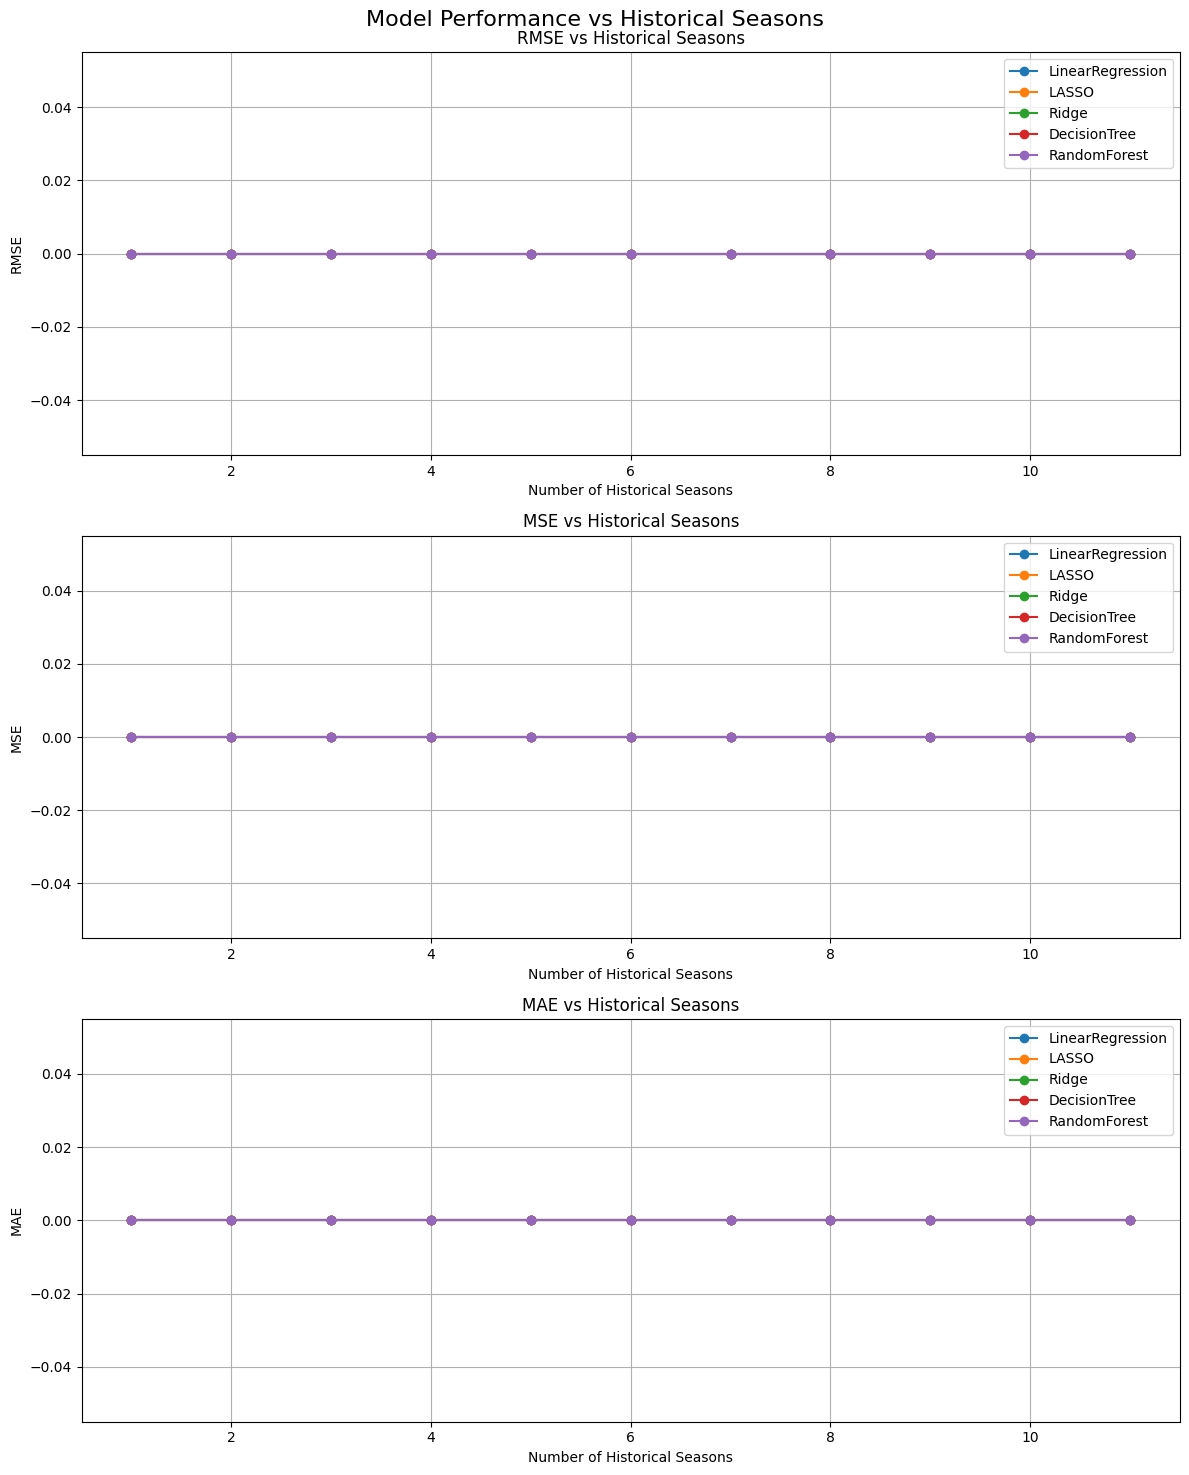

In [ ]:
def preprocess_data(df, target_season, historical_seasons):
    filtered_data = df.copy()

    print(f"Processing seasons: {target_season} and {historical_seasons}")
    print(f"Initial dataframe shape: {filtered_data.shape}")

    season_mask = (filtered_data['teams_season'].isin(historical_seasons)) | (filtered_data['teams_season'] == target_season)
    filtered_data = filtered_data[season_mask]
    print(f"Shape after season filtering: {filtered_data.shape}")

    filtered_data = filtered_data.dropna(subset=['teams_allStarStatus'])
    print(f"Shape after dropping NaN values: {filtered_data.shape}")

    filtered_data['allStarStatus'] = filtered_data['teams_allStarStatus'].apply(lambda x: 1 if x == 'Y' else 0)

    original_index = filtered_data.index

    columns_to_drop = ['teams_allStarStatus', 'teams_season', 'league_abbreviation', 'allStarStatus']
    features = filtered_data.columns.difference(columns_to_drop)

    X = filtered_data[features].copy()
    y = filtered_data['allStarStatus']

    print(f"Feature matrix shape (X): {X.shape}")
    print(f"Target vector shape (y): {y.shape}")

    dict_columns = []
    for col in X.select_dtypes(include=['object']).columns:
        print(f"Processing column: {col}")


        sample_non_null = X[col].dropna().iloc[0] if not X[col].dropna().empty else None

        if isinstance(sample_non_null, dict):
            dict_columns.append(col)
            print(f"Normalizing dictionary column: {col}")
            try:

                X[col] = X[col].fillna({})


                normalized_df = pd.json_normalize(X[col].tolist())


                normalized_df.columns = [f"{col}_{subcol}" for subcol in normalized_df.columns]


                X = X.drop(columns=[col])
                X = pd.concat([X, normalized_df], axis=1)

                print(f"Successfully normalized {col}")
            except Exception as e:
                print(f"Error normalizing {col}: {str(e)}")

                X = X.drop(columns=[col])


    remaining_categorical = X.select_dtypes(include=['object']).columns.difference(dict_columns)


    X_encoded = pd.DataFrame(index=X.index)


    for col in remaining_categorical:

        X[col] = X[col].astype(str).fillna('missing')


        value_counts = X[col].value_counts()
        top_categories = value_counts.nlargest(min(10, len(value_counts))).index


        X[col] = X[col].apply(lambda x: x if x in top_categories else 'other')
        dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
        X_encoded = pd.concat([X_encoded, dummies], axis=1)


    numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
    if not numeric_columns.empty:
        X_encoded = pd.concat([X_encoded, X[numeric_columns]], axis=1)


    X_encoded = X_encoded.fillna(0)


    X_encoded = X_encoded.reindex(original_index)

    print(f"Final shapes after preprocessing:")
    print(f"X shape: {X_encoded.shape}")
    print(f"y shape: {y.shape}")

    return X_encoded, y

def train_and_evaluate(X_train, X_test, y_train, y_test, models):
    """Train models and return their performance metrics"""
    results = {}

    for model_name, model in models.items():
        start_time = time.time()
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            computation_time = time.time() - start_time

            results[model_name] = {
                'RMSE': rmse,
                'MSE': mse,
                'MAE': mae,
                'Computation Time': computation_time
            }
        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            results[model_name] = None

    return results

def incremental_training(df, target_season, historical_seasons):
    """Train models incrementally adding historical seasons"""

    models = {
        'LinearRegression': LinearRegression(),
        'LASSO': Lasso(),
        'Ridge': Ridge(),
        'DecisionTree': DecisionTreeRegressor(),
        'RandomForest': RandomForestRegressor()
    }


    performance_history = {model_name: {'RMSE': [], 'MSE': [], 'MAE': [], 'Seasons': []}
                         for model_name in models.keys()}


    historical_seasons.sort(reverse=True)


    for i in range(1, len(historical_seasons) + 1):
        current_seasons = historical_seasons[:i]
        print(f"\nTraining with seasons: {target_season} and {current_seasons}")


        X, y = preprocess_data(df, target_season, current_seasons)


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


        results = train_and_evaluate(X_train, X_test, y_train, y_test, models)


        for model_name, metrics in results.items():
            if metrics is not None:
                performance_history[model_name]['RMSE'].append(metrics['RMSE'])
                performance_history[model_name]['MSE'].append(metrics['MSE'])
                performance_history[model_name]['MAE'].append(metrics['MAE'])
                performance_history[model_name]['Seasons'].append(len(current_seasons))

    return performance_history

def plot_performance_history(performance_history):
    """Plot the performance metrics over increasing historical seasons"""
    metrics = ['RMSE', 'MSE', 'MAE']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 15))
    fig.suptitle('Model Performance vs Historical Seasons', fontsize=16)

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        for model_name, history in performance_history.items():
            if len(history[metric]) > 0:
                ax.plot(history['Seasons'], history[metric],
                       marker='o', label=model_name)

        ax.set_xlabel('Number of Historical Seasons')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs Historical Seasons')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    return fig


target_season = 2024
historical_seasons = [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]


print("Starting incremental training...")
performance_history = incremental_training(df, target_season, historical_seasons)


print("\nFinal Results:")
for model_name, history in performance_history.items():
    print(f"\n{model_name}:")
    for metric in ['RMSE', 'MSE', 'MAE']:
        if len(history[metric]) > 0:
            print(f"Final {metric}: {history[metric][-1]:.4f}")
            print(f"{metric} Improvement: {history[metric][0] - history[metric][-1]:.4f}")


fig = plot_performance_history(performance_history)


print("\nPerformance Summary:")
for model_name, history in performance_history.items():
    print(f"\n{model_name}:")
    for metric in ['RMSE', 'MSE', 'MAE']:
        if len(history[metric]) > 0:
            print(f"{metric}:")
            print(f"  Best: {min(history[metric]):.4f}")
            print(f"  Worst: {max(history[metric]):.4f}")
            print(f"  Average: {np.mean(history[metric]):.4f}")